# Simple Row-Aggregating Features In The Movielens Dataset 

This example illustrates using `pandas`-munging capabilities in estimators building features that draw from several rows. We will use a single table from the [Movielens dataset](https://grouplens.org/datasets/movielens/) (F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS)).

[Nonnegative Matrix Farcotization In The Movielens Dataset](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) shows a similar example, but using nonnegative matrix factorization.

## Loading The Data

In this example, we'll only use the dataset table describing the ratings themselves. I.e., each row is an instance of a single rating given by a specific user to a specific movie.

In [1]:
import os

from sklearn import base
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.despine()

import ibex
from ibex.sklearn import model_selection as pd_model_selection
from ibex.sklearn import linear_model as pd_linear_model
from ibex.sklearn import ensemble as pd_ensemble

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ratings = pd.read_csv(
    'movielens_data/ml-100k/u.data', 
    sep='\t', 
    header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'])
features = ['user_id', 'item_id']
ratings = ratings.sample(frac=1)
ratings[features + ['rating']].head()

,user_id,item_id,rating
28857,361,150,2
37348,417,69,3
81805,130,771,2
77466,754,922,3
37664,618,724,3


## A Failed Attempt

The subset of the data we've loaded contains very little information - we know nothing about the users or the movies. Perhaps the movie rating mean is a useful feature.

### Wrong Way To Do Cross Validation

Suppose we build a new `DataFrame` composed of the mean rating of the dataset.

In [3]:
mean_rating = pd.DataFrame({'mean': ratings.rating.mean() * np.ones_like(ratings.rating)}, index=ratings.index)

We now check the performance of predicting the rating using the mean rating.

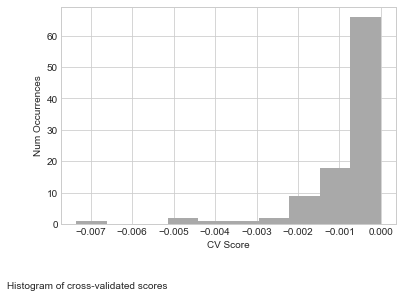

In [4]:
prd = pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(prd, mean_rating, ratings.rating, cv=100),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

The results don't look good. Worse, though, they are not even correct. Since the mean was taken over the entire dataset, the features in each fold "peeked" at the holdout data.

### Correct Way To Do Cross Validation

The correct way of using the mean, is through a `Transformer` object, which, for each train set it gets, computes the mean and remembers it; when asked to predict, it emits the mean of the train data.

In [5]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        return self
        
    def transform(self, X):
        return pd.DataFrame({'mean': self._mean}, index=X.index)

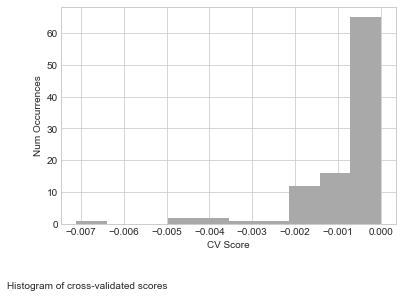

In [6]:
prd = ScoresAggregator() | pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=100),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

Unsuprisingly, the results are even worse than before. Methodically, this is the correct way of building the feature without peeking, and so the CV result should intuitively be weaker.

## Exploratory Analysis Using Pandas

While the subset of the data we've loaded contains very little information, it stands to reason that there still is some information here. For example: 

* A user who rated movies highly, will tend to rate a new movie highly

* A movie which was rated poorly by some users, will tend to be rated low by a new user.

We'll use `pandas` to check indications for this.

First, we calculate the mean standard deviation *within each user's ratings*.

In [7]:
by_user_std = ratings.rating.groupby(ratings.user_id).std()

Now we compare this to the overall standard deviation.

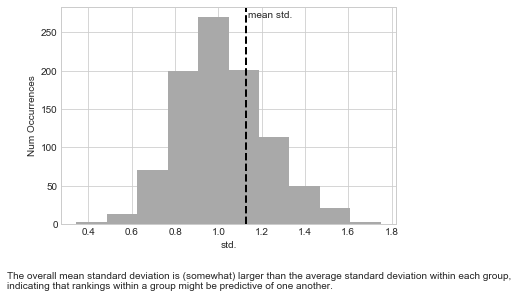

In [8]:
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_user_std)[0]))));
hist(
    by_user_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'The overall mean standard deviation is (somewhat) larger than the average standard deviation within each group,\n' + 
    'indicating that rankings within a group might be predictive of one another.');

The overall standard deviation is somewhat higher than the average per-user standard deviation, which is some indication that known ratings by a user will be an indication for further ratings by the user.

In [9]:
by_item_std = ratings.rating.groupby(ratings.item_id).std().dropna()

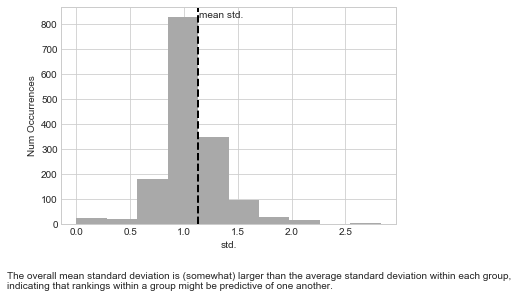

In [10]:
axvline(
    ratings.rating.std(), 
    linewidth=2,
    linestyle='dashed',
    color='black');
annotate(
    'mean std.',
    xy=(1.01 * ratings.rating.std(), int(max(hist(by_item_std)[0]))));
hist(
    by_item_std,
    color='darkgrey');
xlabel('std.')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'The overall mean standard deviation is (somewhat) larger than the average standard deviation within each group,\n' + 
    'indicating that rankings within a group might be predictive of one another.');

Again, there is some (weaker) indication that per-item scores are useful features.  

## Building A Pandas-Munging Estimator

We'll now build a Scikit-Learn / Pandas step doing the above. For each user, we'll store the mean score & number of occurrences.

In [13]:
class ScoresAggregator(base.BaseEstimator, base.TransformerMixin, ibex.FrameMixin):
    def fit(self, X, y):
        self._mean = y.mean()
        self._user_id_stats = y.groupby(X.user_id).agg([np.mean, 'count'])
        self._user_id_stats.columns = ['user_id_mean', 'user_id_count']
        return self
        
    def transform(self, X):
        user_ratings = pd.merge(
            X[['user_id']],
            self._user_id_stats,
            left_on='user_id',
            right_index=True,
            how='left')[['user_id_mean', 'user_id_count']]
        user_ratings.user_id_mean = user_ratings.user_id_mean.fillna(self._mean)
        user_ratings.user_id_count = user_ratings.user_id_count.fillna(0)
        return user_ratings

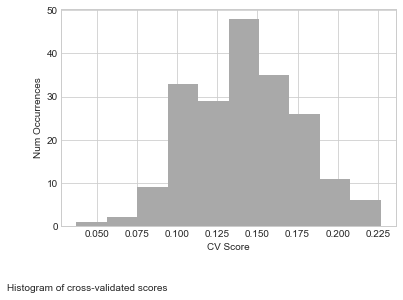

In [14]:
import warnings
warnings.filterwarnings('ignore')

prd = ScoresAggregator() | pd_ensemble.RandomForestRegressor()
hist(
    pd_model_selection.cross_val_score(prd, ratings[features], ratings.rating, cv=200, n_jobs=-1),
    color='darkgrey');
xlabel('CV Score')
ylabel('Num Occurrences')
figtext(
    0, 
    -0.1, 
    'Histogram of cross-validated scores');

The CV histogram indicates that the results are now positive.